# Microsoft Movie Analysis

Author: Rebecca Neel

## Introduction

The purpose of this notebook is to provide an analysis of film data to assist Microsoft in launching a successful new movie studio.

I used data from IMDB, Box Office Mojo, The Numbers and the Movie Database.

The metric for success used is average worldwide gross.

By this metric, Action/Adventure/Science-Fiction is the most successful genre, and releasing a film in late May ensures the highest success rate possible for any given film.

One shouldn't spend more than \\$175 to \\$200 million on production.

**Read on to find out why!**

## Table of Contents

* Import statements and load data
* Transform data
* Business question 1

    Which genre(s) are most successful?
    
* Business question 2

    What production budget is optimal for a successful movie in this genre?
    
* Business question 3

    What time of year do movies with the highest worldwide gross get released?
    
* Appendix

## Import Statements and Load Data

In [42]:
# Import Pandas to use DataFrame datatype
# data from csv and SQL database will be loaded into dataframes
import pandas as pd

# Import numpy for statistical functions (mean, median)
# and as underlying framework for Pandas
import numpy as np

# Import current version of sqlite to connect to the imdb database
import sqlite3

# Import pandasql, to use pandasql for complicated filtering and joining of dataframes
from pandasql import sqldf
psdf = lambda x: sqldf(x, globals())

# Import matplotlib and pyplot, style libraries to create and customize visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# Import seaborn to upgrade visualizations
import seaborn as sns

# Show data visualizations inline (rather than opening a separate window)
%matplotlib inline

# Some data is stored in a string format, but clearly was originally a json
import json # Use json.loads to transform a string into a json

# Some visualizations are printing a warning about passing keyword arguments without a keyword; I am going to suppress it
import warnings
# Ignore warning about passing keyword arguments without an explicit keyword
warnings.filterwarnings("ignore")

In [2]:
# Make a connection to the imdb database (stored in Data folder)
conn = sqlite3.connect('Data/im.db')

# Write query in SQL to select movie_basics & movie_ratings
query = ''' SELECT *
            FROM movie_basics
            JOIN movie_ratings
            USING(movie_id)
            ;'''

# Use Pandas to read data from imdb database query into a dataframe
imdb_movies = pd.read_sql(query, conn)

# Inspect first 5 rows
imdb_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


#### Data from IMDB Database

The imdb_movies dataframe has movie_id (which I won't use, since it is only relevant to connect to other data in the imdb database), primary_title and original_title -- I am going to use the primary_title to connect with other dataframes because this one appears to be in English and I have a feeling that the other dataframes I work with will give the movie title in English, start_year as an integer, runtime_minutes as a float -- with some missing values, genres as a list of comma-separated genres, averagerating as a float (looks to be between 0 and 10), and num_votes as an integer.

In [3]:
# Use Pandas to read csv data from rawData folder into a dataframe
tn_movie_budgets = pd.read_csv('rawData/tn.movie_budgets.csv.gz', compression='gzip')

# Inspect first 5 rows
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


#### Data from The Numbers .csv

The Numbers movie budgets dataframe has an id (irrelevant to other dataframes), release date as a string, movie giving the title of the movie as a string, production budget, domestic gross and worldwide gross. The financial information appears to be stored in a -- possibly nonnumerical? -- format which contains $ and commas, I will need to remove these to calculate statistics on these features.

In [4]:
# Use Pandas to read csv data from rawData folder into a dataframe
bom_movie_gross = pd.read_csv('rawData/bom.movie_gross.csv.gz', compression='gzip')

# Inspect first 5 rows
bom_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


#### Data from Box Office Mojo .csv

I like this dataframe! It's brief and to the point. Gives title - name of movie, studio - initials for studio that released the movie, domestic_gross - float, foreign_gross - float, year - year movie was released as an integer.

In [5]:
# Use Pandas to read csv data from rawData folder into a dataframe
kaggle_tmdb_5000 = pd.read_csv('rawData/tmdb_5000_movies.csv.zip')

# Inspect first 5 rows
kaggle_tmdb_5000.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#### Data from The Movie Database via Kaggle

This dataframe has a wealth of information. Some features look like they are stored in a json format, but they are actually stored as strings. (This is why I imported the json library above -- to convert string-ified jsons back to json format.) The features I am most interested in are budget, genres (if TMDB has genres for any movies for which IMDB fails to provide genre), keywords, release date, runtime and title (name of the movie.)

---

## Transform Data

First, I am creating a function to transform gross revenue (domestic and worldwide) and production budget into floats so that I can calculate summary statistics, like mean, median and quartiles, as well as analyze the average worldwide gross by category.

I am creating a special function to do this because some of the values are already stored as floats, so I cannot apply .map with the lambda function x: float(x) because this throws an error when x is already a float. *Sidenote: I think I could possibly have avoided this by using na_action=Ignore in my .map(lambda x: float(x)) call, but I am not sure. I need to go back and check, because possibly only the null values were stored as floats. I looked into this, but didn't document my findings. =(*

In [6]:
def to_float(value):
    """Takes in a string or float. If string, removes up to 3 commas, 1 $ sign, and whitespace, then converts to float."""
    if type(value) == float:
        # If the value in question is already a float, don't change it (this should include NaNs which are stored as floats)
        
        return value
    else:
        # If not a float, should be a string (at least in this dataset)
        
        # Because .replace() only replaces the first instance of a character found in a string, I am applying .replace() 3
        # times to remove ','s. If there are fewer than 3 commas, then one or more of these calls will have no effect, which
        # I think is fine in this case
        value = value.replace(',', '') # remove 1st comma
        value = value.replace(',', '') # remove 2nd comma (if there is one)
        value = value.replace(',', '') # remove 3rd comma (if there is one)
        
        # Replace the $ (if any) with empty string
        value = value.replace('$', '')
        
        # Remove any whitespace at the beginning or end of the string
        # Is this necessary to convert successfully to a float? Not sure
        value = value.strip()
        
        # Convert the string to a float, as it should now consist only of digits -- no commas or $ signs
        return float(value)

#### Transform budget and revenue columns in tn_movie_budgets to float using custom function (above)

Now I am applying my custom function from above to the production budget, domestic gross and worldwide gross columns of the Numbers movie budgets dataframe, to transform these columns to floats so that I can calculate summary statistics.

In [7]:
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(to_float)

In [8]:
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(to_float)

In [9]:
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(to_float)

#### Transform bom_movie_gross foreign_gross values to float using custom function (above)

I am applying the same custom function from above to the foreign gross column of the Box Office Mojo dataframe, so that I can calculate summary statistics for foreign gross as necessary (or fill in any gaps in worldwide gross by adding together domestic and foreign gross.)

In [10]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].map(to_float)

#### Drop one null value for release date in kaggle_tmdb_5000
There is only one value in this dataset without a release date. I am dropping it, because I can't reliably match it to movies in other dataframes using only title.

In [11]:
kaggle_tmdb_5000.dropna(subset=['release_date'], inplace=True)

### Join all data into one table

Make a field called "movie_year" in all tables, to match records by film title and release year

Before concatenating the values in primary_title/movie with a space and the release year, I need to transform the release year from an integer to a string (for BOM and IMDB.) I do this using the .map() method on the year (for BOM) or start_year (for IMDB) column, passing it the lambda function x: str(x) which uses the Python built-in function str() to convert each value in the column to a string version of that value. The column is not overwritten, as .map() does not modify the original series.

In [12]:
imdb_movies['movie_year'] = imdb_movies['primary_title'] + ' ' + imdb_movies['start_year'].map(lambda x: str(x))

In [13]:
bom_movie_gross['movie_year'] = bom_movie_gross['title'] + ' ' + bom_movie_gross['year'].map(lambda x: str(x))

For the Numbers movie budgets, the release year is stored as part of the string value in the release_date column which also contains the release day and month. The release year is reliably the last 4 characters of this value, so I again use the .map() method, this time on the release_date column, and pass in a lambda function to map each value to its last 4 characters. Because a slice of a string is also a string, no further transformation is needed before concatenation.

In [14]:
tn_movie_budgets['movie_year'] = tn_movie_budgets['movie'] + ' ' + tn_movie_budgets['release_date'].map(lambda x: x[-4:])

For the Kaggle/The Movie Database dataframes, the release year is stored as part of a date-time value in the release_date column. Using the .map() method and another lambda function, the datetime value in the release_date column is converted to a string using the Python built-in function str(), then the last 4 characters of this string are returned. This value is concatenated with the original_title of the movie and a space.

In [15]:
kaggle_tmdb_5000['movie_year'] = kaggle_tmdb_5000['original_title'] + ' ' +\
                                kaggle_tmdb_5000['release_date'].map(lambda x: str(x)[:4])

#### Use pandasql to join the tables on movie_year, and perform an inner join

Pandasql is the easiest method for me personally to use to join these tables. There are too many different ways (in my opinion) to join/ merge/ concatenate dataframes in regular Pandas. I like that PandaSQL has ONE way to merge - by specifying a primary key to join on - and I don't have to think about which *way* (horizontally or vertically) my dataframes are being connected. It also allows me to use the SQL syntax to choose the columns that I want to keep from each table and rename them as desired, and specify the condition that the budget and production_budget values can't both be null, rather than needing to do this extra cleaning as separate function calls after the fact of joining my tables.

In [16]:
query = ''' SELECT t.release_date, t.movie, t.production_budget, t.domestic_gross, t.worldwide_gross,
                    i.primary_title, i.start_year, i.runtime_minutes, i.genres AS imdb_genres,
                    k.genres AS tmdb_genres, k.keywords, k.original_title, k.overview, k.production_companies,
                    k.release_date AS tmdb_release_date, k.runtime AS tmdb_runtime, b.studio, t.movie_year
            FROM tn_movie_budgets as t
            LEFT JOIN imdb_movies as i
            ON i.movie_year = t.movie_year
            LEFT JOIN kaggle_tmdb_5000 as k
            ON i.movie_year = k.movie_year
            LEFT JOIN bom_movie_gross as b
            USING(movie_year)
            WHERE (k.budget IS NOT NULL) | (t.production_budget IS NOT NULL)
            ;
            '''

# store joined tables with non-null budget as a Pandas dataframe
all_movies = psdf(query)

In [17]:
# view summary info about non-null values & datatypes in each column
all_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date          5818 non-null   object 
 1   movie                 5818 non-null   object 
 2   production_budget     5818 non-null   float64
 3   domestic_gross        5818 non-null   float64
 4   worldwide_gross       5818 non-null   float64
 5   primary_title         1498 non-null   object 
 6   start_year            1498 non-null   float64
 7   runtime_minutes       1490 non-null   float64
 8   imdb_genres           1496 non-null   object 
 9   tmdb_genres           977 non-null    object 
 10  keywords              977 non-null    object 
 11  original_title        977 non-null    object 
 12  overview              976 non-null    object 
 13  production_companies  977 non-null    object 
 14  tmdb_release_date     977 non-null    object 
 15  tmdb_runtime         

Surprisingly, genre is going to be the limiting factor on how many films I can use for my analysis; it has the fewest non-null values of the interesting features. (Although actually keywords has potentially even fewer non-null values.) I see that I have fewer tmdb_genres than imdb_genres. Ideally, there would be no overlap, and thetere would be 1496 + 977 movies with genres, but this is probably not the case. I need to look for overlap and make one genres column with genres for as many films as possible, from either source.

---

### Aside: Which specific individual movies have the highest worldwide gross?

Aside from grouping films by category and looking at average worldwide gross, I am curious - what are the most successful films, period? (I.e. films that have garnered the highest worldwide gross.)

In [18]:
all_movies.loc[all_movies.worldwide_gross.sort_values(ascending=False)[:10].index]
# Within the brackets, I am sorting the worldwide gross column of all_movies in descending order, and limiting this list to
# the first 10, to give me the worldwide gross of the 10 movies with the highest worldwide gross, in descending order.
# Then I am grabbing the index of this series, which connects each film back to all of its information in the all_movies
# dataframe. Now I can use .loc to find the records for these films, and list all of the features, including title.

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,imdb_genres,tmdb_genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Avatar 2009
42,"Dec 19, 1997",Titanic,200000000.0,659363944.0,2.208208e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Titanic 1997
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Star Wars Ep. VII: The Force Awakens 2015
6,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,None,NaN,BV,Avengers: Infinity War 2018
33,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09,Jurassic World,2015.0,124.0,"Action,Adventure,Sci-Fi","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1299, ""name"": ""monster""}, {""id"": 1718,...",Jurassic World,Twenty-two years after the events of Jurassic ...,"[{""name"": ""Universal Studios"", ""id"": 13}, {""na...",2015-06-09,124.0,Uni.,Jurassic World 2015
67,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 28, ""name"": ""Action""}]","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...",2015-04-01,137.0,Uni.,Furious 7 2015
26,"May 4, 2012",The Avengers,225000000.0,623279547.0,1.517936e+09,The Avengers,2012.0,143.0,"Action,Adventure,Sci-Fi","[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 242, ""name"": ""new york""}, {""id"": 5539,...",The Avengers,When an unexpected enemy emerges and threatens...,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",2012-04-25,143.0,None,The Avengers 2012
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",2015-04-22,141.0,BV,Avengers: Age of Ultron 2015
41,"Feb 16, 2018",Black Panther,200000000.0,700059566.0,1.348258e+09,Black Panther,2018.0,134.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,None,NaN,BV,Black Panther 2018
262,"Jul 15, 2011",Harry Potter and the Deathly Hallows: Part II,125000000.0,381193157.0,1.341693e+09,None,NaN,NaN,None,None,None,None,None,None,None,NaN,None,Harry Potter and the Deathly Hallows: Part II ...


It doesn't surprise me to see that Avatar is the highest grossing film (in terms of worldwide gross) in this dataset. I see a lot of names that I recognize, which gives me some confidence that the films in this dataset are not a sample of extremely niche films that haven't gained a lot of popularity. All 10 of the top 10 films have brought in upwards of 1 BILLION dollars.

--- 

## Metric for Success: Average Worldwide Gross

Before continuing, I want to understand the distribution of the worldwide gross feature of the films in my dataset, since I am planning to use the average worldwide gross as a success metric for these films.

The average worldwide gross is an appropriate success metric because it represents the popularity & revenue of an "average" film of a certain type. If we make a type of film which is, on average, popular and brings in a reasonable revenue, I think that this is a good starting point. Then we can check that the entire distribution of films of that type is reasonable.

In [102]:
# Get summary statistics for worlwide gross of all movies
all_movies.describe()['worldwide_gross']

count    5.818000e+03
mean     9.146962e+07
std      1.749428e+08
min      0.000000e+00
25%      4.125415e+06
50%      2.794748e+07
75%      9.750994e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

In [90]:
# Calculate the interquartile range for the worldwide gross (of all movies)
worldwide_gross_iqr = all_movies['worldwide_gross'].quantile(q=0.75) - all_movies['worldwide_gross'].quantile(q=0.25)

# Locate records for outliers that grossed significantly more than the average
all_movies.loc[ all_movies.worldwide_gross > (1.5*worldwide_gross_iqr + all_movies['worldwide_gross'].quantile(q=0.75)) ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Avatar 2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy","[{""id"": 658, ""name"": ""sea""}, {""id"": 1316, ""nam...",Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2011-05-14,136.0,BV,Pirates of the Caribbean: On Stranger Tides 2011
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",2015-04-22,141.0,BV,Avengers: Age of Ultron 2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Star Wars Ep. VIII: The Last Jedi 2017
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Star Wars Ep. VII: The Force Awakens 2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,"Dec 15, 1939",Gone with the Wind,3900000.0,198680470.0,3.905252e+08,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Gone with the Wind 1939
4619,"Aug 13, 1997",The Full Monty,3500000.0,45950122.0,2.612494e+08,None,NaN,NaN,None,None,None,None,None,None,NaN,None,The Full Monty 1997
4806,"Feb 15, 1950",Cinderella,2900000.0,85000000.0,2.635914e+08,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Cinderella 1950
5379,"Aug 13, 1942",Bambi,858000.0,102797000.0,2.680000e+08,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Bambi 1942


In [100]:
len(all_movies) - 609

5209

There are 609 outliers that made significantly more than the average in terms of worldwide gross. Some of these don't contain genre information, so we'll see if we need to deal with these after we drop records with null values for genre.

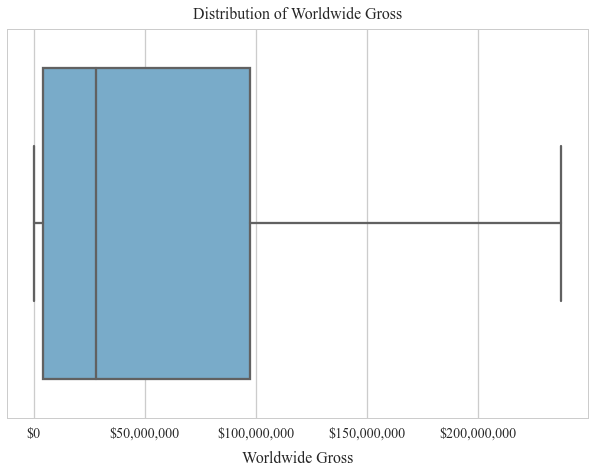

In [101]:
# Visualize the distribution of worldwide gross (of all movies) using a boxplot
fig, ax = plt.subplots()

# Use consistent palette throughout
# In this case, do not show outliers, they pretty much ruin the plot
sns.boxplot(all_movies['worldwide_gross'], showfliers=False, palette='Blues_r')

# Set title, x-axis label & text properties
ax.set_title('Distribution of Worldwide Gross', fontname='Times New Roman', fontsize=16, pad=10)
ax.set_xlabel('Worldwide Gross', fontname='Times New Roman', fontsize=16, labelpad=10)
[ t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# do not use scientific notation for x-axis tick labels
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

# Save figure
fig.savefig('Images/wwgross_all.png', bbox_inches='tight');

## Business Question: What are the most successful genre(s)?
### Metric: Average Worldwide Gross

How does the average worldwide gross of a film vary (or fail to vary) according to genre?

### Additional Data Cleaning for Genre Analysis

In [19]:
# since tmdb_genres only adds info for one record, transfer that data to imdb_genres, drop tmdb_genres & rename imdb_genres
# as 'genres'

# transfer genre from tmdb_genres to imdb_genres for record 1278
all_movies.loc[1278, 'imdb_genres'] = 'Action'

# drop the tmdb_genres column, as it no longer contains any unique information
all_movies.drop(axis=1, labels='tmdb_genres', inplace=True)

# rename imdb_genres column to "genres", make this change inplace after checking for errors
all_movies.rename(columns={'imdb_genres':'genres'}, inplace=True)

In [20]:
# make a copy of movies for genre analysis
movies_w_genres = all_movies.copy()

# drop records for which GENRE is null
movies_w_genres.dropna(subset=['genres'], inplace=True)

In [21]:
# I expect 1497 records based on imdb_genres having 1496 non-null values + 1 added value from tmdb_genres
len(movies_w_genres)

1497

### Group by Genres & Look at Mean Worldwide Gross

In [22]:
# Group by genre, using aggreggate function .mean() (Pandas function), and look at worldwide_gross column.
# Then sort values in descending order; this should put genres with highest average worldwide gross on top.

movies_w_genres.groupby('genres').mean()['worldwide_gross'].sort_values(ascending=False)

genres
Family,Fantasy,Musical     1.259200e+09
Fantasy,Musical            1.025491e+09
Adventure,Fantasy          7.012107e+08
Adventure,Drama,Sci-Fi     6.608254e+08
Action,Adventure,Sci-Fi    6.578237e+08
                               ...     
Family                     0.000000e+00
Action,Crime,Fantasy       0.000000e+00
Animation                  0.000000e+00
Comedy,Mystery,Thriller    0.000000e+00
Western                    0.000000e+00
Name: worldwide_gross, Length: 229, dtype: float64

I am surprised to see that "Family, Fantasy, Musical" is the highest average grossing genre. Are there enough movies of this genre in my sample to draw a conclusion about all films in this genre? I am going to filter my data to only include genres for which 30 or more films exist in my dataset.

#### Limit data to genres with at least 30 films in dataset

I just don't believe that "Family, Fantasy, Musical" is the highest grossing type of film (on average.) So I suspect that my sample size for that genre -- and, therefore, possibly others -- is too small.

In [23]:
# Again, Pandasql seems like the easiest way to approach this problem, instead of grouping the overall dataframe by genre
# & somehow using an aggregate function to count the number of films in that genre first, then using those indices to
# regroup by genre & use the mean aggregate function

# I am grabbing the genre, the number of films in that genre, and the average worldwide gross for genres with atleast
# 30 films in the data set. Again, the list is ordered by average worldwide gross, descending.
query = ''' SELECT genres, COUNT() AS num_films, AVG(worldwide_gross) AS avg_gross
            FROM movies_w_genres
            GROUP BY genres
            HAVING num_films >= 30
            ORDER BY avg_gross DESC
        ;
        '''

# Store results of grouping by genre & filtering for at least 30 films, then ordering by avg gross, in a new dataframe
genres_atleast_30_films = psdf(query)

Base on this new criteria (at least 30 films in the dataset), I only have 12 genres for which enough data exists in my sample to draw conclusions about all films.

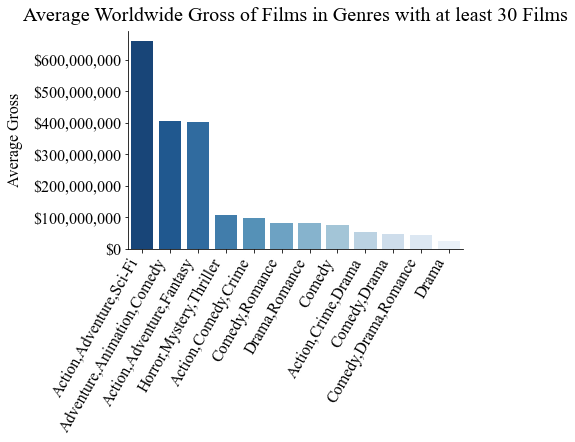

In [41]:
# Create a bar chart to visualize the average worldwide gross by genre, in descending order (data is already ordered)

# Create a figure and axis
fig, ax = plt.subplots()

# Use seaborn and the palette Blues_r (so that higher average worldwide gross is darker)
sns.barplot(genres_atleast_30_films['genres'], genres_atleast_30_films['avg_gross'], palette='Blues_r')

# Rotate x tick labels 60 deg (to avoid overlapping text) and align the right end of each label to the tickmark
plt.xticks(rotation=60, ha='right')

# Set the title individually to specify fontname, fontsize and padding (so that title is not too close to plot)
ax.set_title('Average Worldwide Gross of Films in Genres with at least 30 Films', fontname= 'Times New Roman', fontsize=20,\
             pad=10)

# Re-pass x-axis tick labels & specify fontname, fontsize this time
ax.set_xticklabels(genres_atleast_30_films['genres'], fontname='Times New Roman', fontsize=16)

# Remove x-axis label
ax.set_xlabel('')

# Set y-axis label & specify, fontname, fontsize and labelpad (so that label is not too close to plot)
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)

# Set fontname and fontsize for each tick-label on y-axis, without passing in labels themselves
# (I like the auto-generated y-axis labels, I just want to modify the font)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(16) for t in ax.yaxis.get_ticklabels()]

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# I don't like scientific notation for y-axis labels
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

# Save figure to Images folder; set bbox_inches parameter to "tight" to avoid cutting off part of the figure when saving
fig.savefig('Images/avg_gross_all_genres', bbox_inches='tight');

#### We have 3 clear "winners" in terms of genre

The top 3 most successful genres out-gross the other genres by 4 fold or more, on average. I was originally only going to display the top 3 most successful genres in my presentation, which are below, but ended up showing the whole barchart to illustrate how much *more* you can make with the top 3 genres.

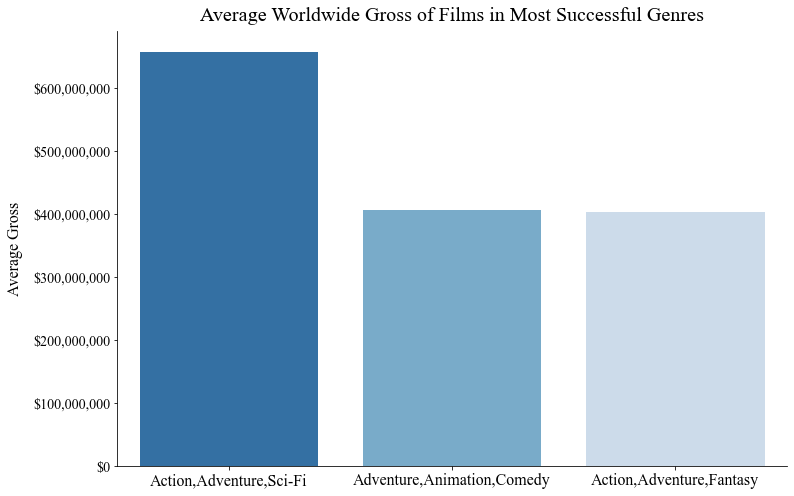

In [40]:
# Create a bar chart for top 3 genres only

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,8))

# Use seaborn and the palette Blues_r (so that higher average worldwide gross is darker)
sns.barplot(genres_atleast_30_films['genres'][:3], genres_atleast_30_films['avg_gross'][:3], ax=ax, palette='Blues_r')
# I am not sure why I specified ax = ax here; I don't think it is necessary since I only have one axes

# Pass title & set text properties for title; include pad to put a little space between title and plot
ax.set_title('Average Worldwide Gross of Films in Most Successful Genres', fontname= 'Times New Roman', fontsize=20, pad=10)

# Pass x tick labels & set text properties for x tick labels
ax.set_xticklabels(genres_atleast_30_films['genres'][:3], fontname='Times New Roman', fontsize=16)

# Suppress x-axis label
ax.set_xlabel('')

# Pass y-axis label & set text properties
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)

# Set text properties for y-axis tick labels, without passing in y-axis tick labels (use auto-generated)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

# Don't use scientific notation for y-axis labels
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt);

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

Before I make any final conclusions about what to recommend, I want to dig into the distribution of worldwide gross for movies in each of these genres.

---

## Business Question
### What is the optimal production budget for an Action/Adventure/Science-Fiction film?

Create a dataframe which contains records only for Action/Adventure/Science-Fiction films.

In [33]:
top_genre = movies_w_genres.loc[ movies_w_genres['genres'] == 'Action,Adventure,Sci-Fi' ]

In [34]:
# Inspect first 5 rows
top_genre.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year
2,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,NaN,None,Dark Phoenix 2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",2015-04-22,141.0,BV,Avengers: Age of Ultron 2015
6,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,NaN,BV,Avengers: Infinity War 2018
13,"Mar 9, 2012",John Carter,275000000.0,73058679.0,2.827781e+08,John Carter,2012.0,132.0,"Action,Adventure,Sci-Fi","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",John Carter,"John Carter is a war-weary, former military ca...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,132.0,BV,John Carter 2012
16,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,Captain America: Civil War,2016.0,147.0,"Action,Adventure,Sci-Fi","[{""id"": 393, ""name"": ""civil war""}, {""id"": 6091...",Captain America: Civil War,"Following the events of Age of Ultron, the col...","[{""name"": ""Studio Babelsberg"", ""id"": 264}, {""n...",2016-04-27,147.0,BV,Captain America: Civil War 2016


In [35]:
# get summary stats for action/adventure/sci-fi films production budgets
top_genre['production_budget'].describe()

count    5.200000e+01
mean     1.731615e+08
std      6.501732e+07
min      1.800000e+06
25%      1.400000e+08
50%      1.725000e+08
75%      2.000000e+08
max      3.500000e+08
Name: production_budget, dtype: float64

In [37]:
# get summary stats for action/adventure/sci-fi films worldwide gross
top_genre['worldwide_gross'].describe()

count    5.200000e+01
mean     6.578237e+08
std      4.475266e+08
min      0.000000e+00
25%      3.505068e+08
50%      5.609138e+08
75%      8.686926e+08
max      2.048134e+09
Name: worldwide_gross, dtype: float64

#### Action Adventure Science-Fiction films / Distribution of Worldwide Gross

Create a box plot to analyze the distribution of worldwide gross for Action/Adventure/Sci-Fi movies.

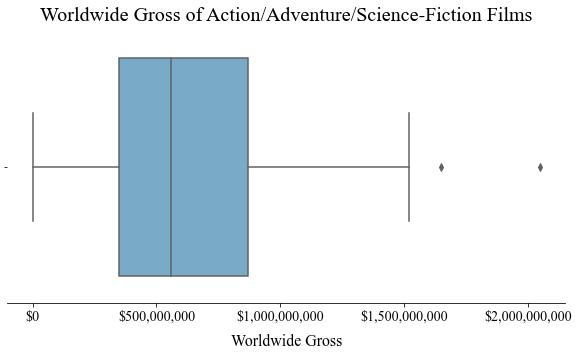

In [38]:
fig, ax = plt.subplots(figsize=(10,5)) # I chose this figure size via experimentation.

sns.boxplot(top_genre['worldwide_gross'], ax=ax, palette='Blues_r') # Use the same palette as for barcharts (consistent)

# Set title, x-axis label & text properties for title, x-axis label & x-axis ticklabels
ax.set_title('Worldwide Gross of Action/Adventure/Science-Fiction Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# don't use scientific notation
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

# save figure
fig.savefig('Images/top_genre_distribution', bbox_inches='tight');

There are two relatively extreme outliers.
1. I want to know which films are the outliers, especially since they are outliers in the "successful" direction.
2. I also need to consider the fact that the outliers affect the mean. Perhaps the median is a better measure of center.

I considered putting the x-axis tick labels in billions, but realized this was only relevant for < 25% of the data. But putting the x-axis ticklabels in millions looked weird because of the upper 25%, so I left it as a number to the ones place.

#### Action Adventure Science-Fiction films / Distribution of Worldwide Gross without Outliers

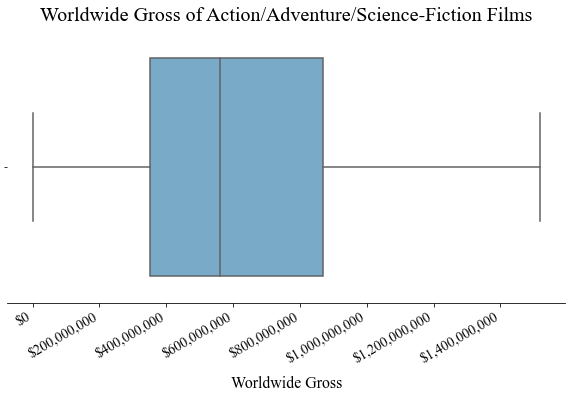

In [39]:
# same box plot as above, but without outliers, using showfliers=False parameter value in sns.boxplot() call

fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(top_genre['worldwide_gross'], ax=ax, palette='Blues_r', showfliers=False)

# Set title, x-axis label & text properties for title, x-axis label & x-axis ticklabels
ax.set_title('Worldwide Gross of Action/Adventure/Science-Fiction Films', fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')
[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels() ]
[ t.set_fontsize(14) for t in ax.xaxis.get_ticklabels() ]

# don't show the axes spines
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# don't use scientific notation
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)

# rotate x-axis ticklabels to avoid text overlap
plt.xticks(rotation=30, ha='right');

I actually like the original boxplot, with the outliers, better. Not only is the x-axis tick labeling easier to read -- I guess less granular = more room between labels --, but I don't think that the more granular x-axis tick labels here actually help you to see what the distribution is like (it's pretty easy to estimate the above information visually in the original boxplot, even though it is not explicitly stated that the middle 50% lie between \\$400 and \\$800 million), and I like seeing the tantalizing possibility of making upwards of \\$2 billion. I also want to point out the outliers and state what films they are, because I would be SO curious if I was a member of the audience.

#### Action Adventure Science-Fiction films / Percentage that Break Even
Roughly 96% of films in this genre breakeven.

In [48]:
# I am using the .loc function to get the records with genre "Action/Adventure/Sci-Fi" for which worldwide gross is greater
# than or equal to production budget, finding the length of this dataframe (# of records), then dividing by the length of
# the dataframe with genre "Action/Adventure/Sci-Fi" & no conditions on worlwide gross and production budget.
# I went back to the movies_w_genres dataframe, so that I could have worldwide gross & production budget together, instead
# of using the genre1_budget and genre1_gross dataframes.

len( top_genre.loc[ top_genre['worldwide_gross'] >= top_genre['production_budget'] ] ) / len(top_genre)

0.9615384615384616

#### Action Adventure Science-Fiction films / Outliers
I am using 
[this method](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244#:~:text=Using%20the%20Interquartile%20Rule%20to%20Find%20Outliers&text=Calculate%20the%20interquartile%20range%20for,this%20is%20a%20suspected%20outlier.) to find the outliers in the worldwide gross boxplot for action/adventure/sci-fi films.

In [45]:
# I am computing the outliers in the worldwide gross boxplot for action/adventure/sci-films; see above for method.

genre1_q1 = top_genre['worldwide_gross'].quantile(q=0.25) # Find 25th %-ile of action/adv/sci-fi films worldwide gross
genre1_q3 = top_genre['worldwide_gross'].quantile(q=0.75) # Find 75th %-ile of action/adv/sci-fi films worldwide gross
genre1_iqr = genre1_q3 - genre1_q1 # Find the interquartile range, the difference of 75th %-ile and 25th %-ile

# Use .loc to get movie title & worldwide gross for movies with worldwide gross 1.5 times the interquartile range GREATER
# than the 75th percentile
top_genre.loc[ top_genre['worldwide_gross'] >= genre1_q3 + 1.5*genre1_iqr, ['movie', 'worldwide_gross'] ]

,movie,worldwide_gross
6,Avengers: Infinity War,2.048134e+09
33,Jurassic World,1.648855e+09


"Avengers: Infinity War" and "Jurassic World" are the outliers in the action/adventure/sci-fi genre which made so much money.

#### Action Adventure Science-Fiction films / Average Production Budget
The average production budget of a film in this genre is \\$173,161,530, or about $175 million.

In [46]:
# Find the mean of the production budget series for action/adventure/sci-fi films, genre1_budget
top_genre_avg_budget = top_genre.mean().values[0]

print(f'The average production budget of a film in this genre is {round(top_genre_avg_budget,0)}.')

The average production budget of a film in this genre is 173161538.0.


#### Action Adventure Science-Fiction films / Correlation between Production Budget and Worldwide Gross
There is a moderate positive correlation (~50%) between production budget and worldwide gross.

In [47]:
# Use numpy corrcoef to get correlation coefficient matrix for production budget, worldwide gross; grab relevant element
np.corrcoef(top_genre['production_budget'], top_genre['worldwide_gross'])[0][1]

0.4960438957902136

Create a scatter plot to explore the correlation visually between production budget and worldwide gross.

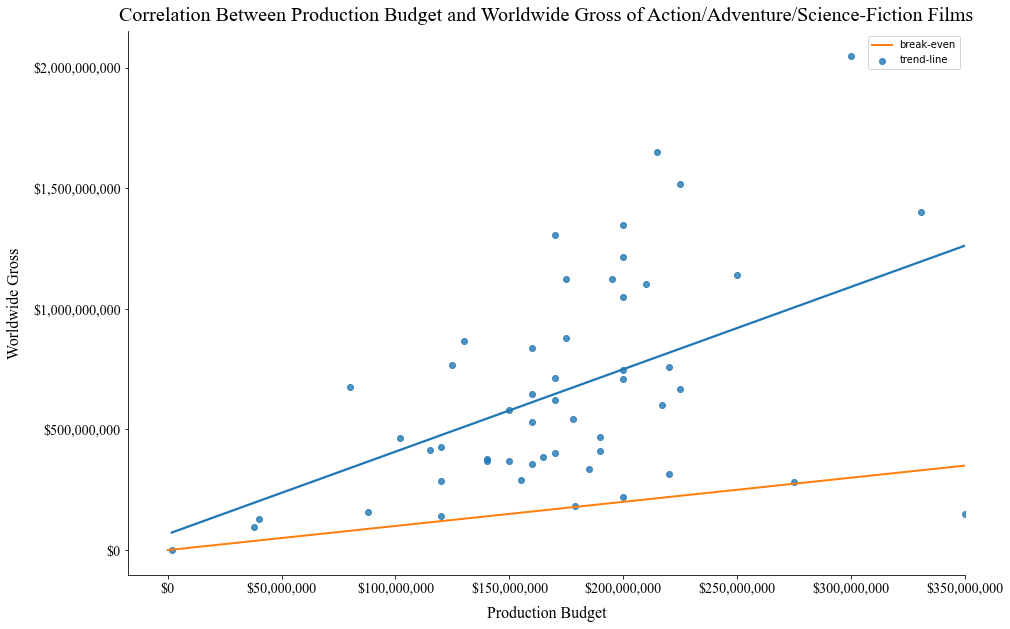

In [49]:
# Create a figure and axes; specify figure size
fig, ax = plt.subplots(figsize=(15,10))

# For a breakeven line, I am going to plot y=x

# Create a list of 1 million equally spaced values between 0 and 350 million
x = np.linspace(0, 350000000, 1000000)
# Make a copy of the x-coords named y, to be the y-coords (I guess I could have used the same list for both, but this is
# more descriptive =) )
y = x

# Plot production budget vs worldwide gross to explore weak positive correlation
# To show the trendline, use sns.regplot instead of sns.scatterplot; set ci=None so that confidence interval band is not
# shown; label the trendline "trend-line" so that this will show up in legend
sns.regplot(top_genre['production_budget'], top_genre['worldwide_gross'], ax=ax, ci=None, label='trend-line')
# on the same axes, plot x versus y and label "break-even" so that y=x will show up as the break-even point in the legend
ax.plot(x, y, linewidth=2, label='break-even')

# Pass title, x-axis and y-axis labels, and set all the text properties (fontname and fontsize, padding / labelpad)
ax.set_title('Correlation Between Production Budget and Worldwide Gross of Action/Adventure/Science-Fiction Films',\
             fontsize=20, pad=10, fontname='Times New Roman')
ax.set_xlabel('Production Budget', fontsize=16, labelpad=10, fontname='Times New Roman')
ax.set_ylabel('Worldwide Gross', fontsize=16, labelpad=10, fontname='Times New Roman')

# Do not use scientific notation, for x-axis or y-axis
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.xaxis.set_major_formatter(gross_fmt)
ax.yaxis.set_major_formatter(gross_fmt)

# Set text properties for x-axis and y-axis ticklabels, without passing in the labels themselves
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

[t.set_fontname('Times New Roman') for t in ax.xaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.xaxis.get_ticklabels()]

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show legend with labels for trend-line and break-even line
ax.legend()

# Save figure
fig.savefig('Images/correlation_production_budget_and_gross', bbox_inches='tight');

---

## Business Question: Which release date(s) generate the most revenue?
### Metric: Average Worldwide Gross,

How does the average worldwide gross of a film vary (or fail to vary) according to release date?

### Methodology
I want to go beyond the month of release and look at three "bands" per month: early in the month, middle of the month and late in the month.

These bands are *granular* enough to provide precise guidance on when to release a movie -- but still *broad* enough to ensure that at least one weekend per month falls into each category, regardless of calendar variations from year to year.

### Additional Data Cleaning for Release Date Analysis
Release dates in the following days of the month correspond to the given release "bands":

| Release Band | Days of Month |
| ------------ | ------------- |
| early-month  |    1-10       |
|  mid-month   |    11-21      |
| late-month   |    22-end     |

In [51]:
# make a copy of the all_movies dataframe, to preserve original dataframe
movie_dates = all_movies.copy()

# create a new column called release month which contains a string with the three-character abbreviation for the month
movie_dates['release_month'] = movie_dates.release_date.map(lambda x: x[:3]) #first three characters in release_date are mon

# create a custom function to take in the value in the release_date column & return early-month, mid-month or late-month
# this will create our release categories!
def part_of_month(value):
    ''' Decide, based on date as string, whether date is early, mid or late in the month.'''
    # the value in question is from the release_date column; this value is a string in which
    # characters 4 & 5 either contain the 2-digit day of the month, or the 1-digit day of the month followed by a comma.
    # strip the comma (if there is one), then convert the remaining value to an integer, called day_of_month.
    day_of_month = int(value[4:6].replace(',', ''))
    if day_of_month < 11:
        return 'early'
    elif day_of_month < 22:
        return 'mid'
    else:
        return 'late'

# map release_date to early, mid or late with custom function, then concatenate with a dash and the month abbreviation
# store in release_category column
movie_dates['release_category'] = movie_dates['release_date'].map(part_of_month) +'-' + movie_dates.release_month

In [52]:
movie_dates.head(3) # Inspect first 3 rows; release_category column looks good!

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,release_month,release_category
0,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,None,NaN,NaN,None,None,None,None,None,None,NaN,None,Avatar 2009,Dec,mid-Dec
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy","[{""id"": 658, ""name"": ""sea""}, {""id"": 1316, ""nam...",Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2011-05-14,136.0,BV,Pirates of the Caribbean: On Stranger Tides 2011,May,mid-May
2,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi",None,None,None,None,None,NaN,None,Dark Phoenix 2019,Jun,early-Jun


First, let's check - are there any times of year that less than 30 movies are released? These release bands should be excluded from our analysis, because we don't have a large enough sample of these types of movies to draw valid conclusions about the population.

In [53]:
# I find PandaSQL to be the easiest way to group by a category & filter by the results of an aggregate function applied to
# each group

# Select any release categories which have an insufficient number of films released during that category.
query = ''' SELECT release_category
            FROM movie_dates
            GROUP BY release_category
            HAVING COUNT() < 30
            ;
            '''
# Simply inspect the results; don't need to save
psdf(query)

,release_category


Fortunately, at least 30 movies have been released in each release category, so I feel confident enough that we can extrapolate from our sample to the entire population of films produced.

### Group by Release Categories & Look at Mean Worldwide Gross

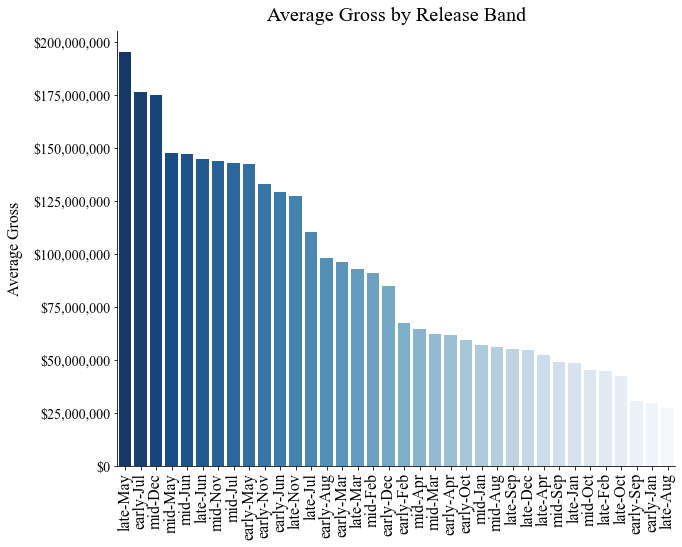

In [54]:
# Group movies by release_category, and find the mean of each column; select worldwide_gross column; sort in descend order
releaseband_avg_gross = movie_dates.groupby('release_category').mean()['worldwide_gross'].sort_values(ascending=False)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot a barplot of the average worldwide gross for each release category; keep using palette Blues_r for consistency
sns.barplot(releaseband_avg_gross.index, releaseband_avg_gross, ax=ax, palette='Blues_r')

# Pass title, x tick labels, y-axis label & set text properties; set y-axis ticklabel text properties w/o passing labels
# Suppress x-axis label
ax.set_title('Average Gross by Release Band', fontname= 'Times New Roman', fontsize=20, pad=10)
ax.set_xticklabels(releaseband_avg_gross.index, fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

# make y-axis numbers more readable; get rid of scientific notation
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

# rotate x-axis ticks 90 degrees
plt.xticks(rotation=90)

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save figure
fig.savefig('Images/avg_gross_by_release.png', bbox_inches='tight');

#### Again, there is a clear  "top 3"

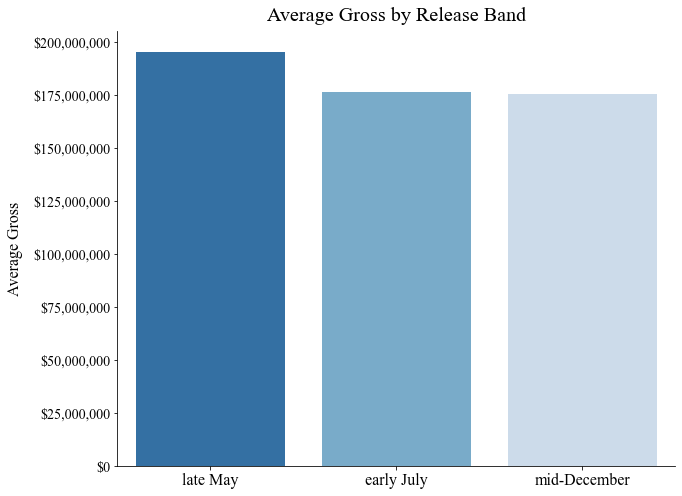

In [55]:
# limit above series with average worldwide gross by release category to the top 3
releaseband_avg_gross_top3 = movie_dates.groupby('release_category').mean()['worldwide_gross'].sort_values(ascending=False)\
[:3]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot barchart of top 3 release categories by average worldwide gross
sns.barplot(releaseband_avg_gross_top3.index, releaseband_avg_gross_top3, palette='Blues_r', ax=ax)

# Set tiles, labels & text properties (fontname, fontsize and pad/labelpad)
ax.set_title('Average Gross by Release Band', fontname= 'Times New Roman', fontsize=20, pad=10)
ax.set_xticklabels(['late May', 'early July', 'mid-December'], fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Average Gross', fontname='Times New Roman', fontsize=16, labelpad=10)
[t.set_fontname('Times New Roman') for t in ax.yaxis.get_ticklabels()]
[t.set_fontsize(14) for t in ax.yaxis.get_ticklabels()]

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# make y-axis numbers more readable; get rid of scientific notation
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt);

---


## Conclusion

The most successful genre, in terms of average worldwide gross, is a combination of Action, Adventure, and Science-Fiction. The average is skewed by two extreme outliers in this genre, but the median worldwide gross is still over \\$100 million higher than the next-leading genre's average, so I feel confident stating that this genre is the most successful. I recommend that Microsoft make a movie with Action, Adventure and Science-Fiction elements to capitalize on the proven success of this genre to establish themselves as a legitimate studio in the film industry.

Additionally, 96\% of Action/Adventure/Science-Fiction films broke even. There is a weak to moderate positive correlation between production budget and worldwide gross. Based on the scatter plot visualizing this correlation, I recommend staying within \\$25 million of the average production budget for this type of film, \\$173 million, to minimize the risk of overspending, but still put the film in the running with films that have made a higher worldwide gross.

Finally, movies released in late May bring in more worldwide gross, on average, than movies released at any other time. I recommend that Microsoft release their movie in late May. Early July and mid-December are also high-grossing times, on average, to release a film, so these are my secondary recommendations.

In establishing itself as a major player in the film industry, Microsoft can generate the greatest worldwide gross and, therefore, name recognition for their studio in the industry, by producing an Action/Adventure/Science-Fiction film for \\$175 to \\$200 million and releasing it in late May.

---

## Appendix
The appendix contains pieces of code that I want to be able to reference in the future, even though the corresponding visualizations or statistics didn't yield reportable insights about the data, or significant work that I did on analysis of the data which didn't influence my final recommendations, but nonetheless, provides insight into the data.

#### Barplot Modifications: Set Color of Each Bar, and Position Annotations according to Height, Width and Position of Bars

In my original release categories barchart, I sorted release categories by total worldwide gross, instead of average worldwide gross, and I put the number of films released at that time of year as an annotation over the bar. I also correlated the opacity of each bar to the number of films released during that release band -- more opaque bars correspond to release categories in which more movies have been released; therefore, you should consider that the higher total worldwide gross doesn't necessarily mean that the average movie released at this time makes more. I ultimately decided that this visualization was confusing -- why not just plot average worldwide gross directly instead? -- but I kept it in the appendix because the granular control over opacity of the bars and the location of the annotation relative to the top of the bar is pretty cool.

<ipython-input-56-1e276e087c6f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = data.index, fontname='Times New Roman')


''

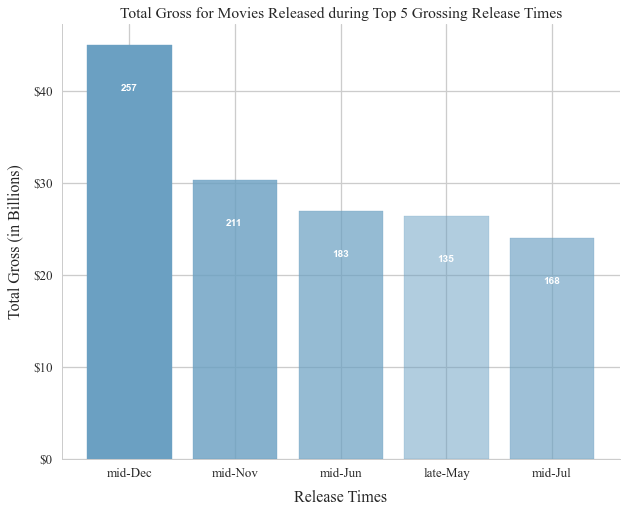

In [56]:
# I was in the habit at this time of naming the data to be used in any plot "data" xD
# Group movies by release_category, find the total worldwide gross for each & get top 5 in descending order
data = movie_dates.groupby('release_category').sum()['worldwide_gross'].sort_values(ascending=False)[:5]

# I ended up not using the style library from matplotlib in my final visualizations
# Also I don't know if this applied because I didn't make my barplot with seaborn? Maybe I did use seaborn at one point?
style.use('seaborn-talk')
style.use('seaborn-whitegrid')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,8))

# Make a list of the number of movies released in each release category
# Iterate over each category in the index for the top 5 release_categories
# Get the value for that category from the .value_counts() series for the release_category column of the original dataframe
num_movies = [ movie_dates['release_category'].value_counts()[category] for category in data.index ]

# ax.bar returns a "BarContainer", something like a list of the individual bars (patches?) in the plot; name it "bars"
# this gives you precise control over the color & opacity of each bar
bars = ax.bar(data.index, data/1000000000) # I was dividing the heights at this time, instead of using mpl.ticker.StrMethodF

# set title, axis labels & specify text properties of each
ax.set_title(label='Total Gross for Movies Released during Top 5 Grossing Release Times', fontname='Times New Roman')

ax.set_xlabel('Release Times', fontname='Times New Roman', fontsize=16, labelpad=10)
ax.set_ylabel('Total Gross (in Billions)', fontname='Times New Roman', fontsize=16, labelpad=10)

ax.set_xticklabels(labels = data.index, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

# remove top, right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set opacity of each bar to correspond to number of movies released in that category (in our dataset)
for i in range(len(num_movies)):
    bars[i].set_color((107/255, 160/255, 194/255, num_movies[i]/max(num_movies)))
    # the color is set here using an rgba value; red, green, blue are between 0 and 1, & alpha is opacity between 0 & 1
    # opacity (alpha) is determined by a ratio of the number of movies released in this release category to the number of
    # movies released in the release category with the most movies released
    
    # I don't remember how I picked the color =( I think I played around with making different shades of the same color
    # using rgb principles, linked to the number of movies released in that release category, but I never quite figured it
    # out (it was something like, 255 + 0.5*(255 - x) where x was the original amount of red/green/or blue and 0.5 in this
    # case is "how much" darker or lighter you wanted the tint to be - like 50% darker).
    # I was going to use the ratio of number of movies to max number of movies as the "how much" darker or lighter.

# Did not ultimately use: set left and bottom spine colors to match fully opaque bar
# ax.spines['left'].set_color((0.6,0.1,0.8, 1))
# ax.spines['bottom'].set_color((0.6,0.1,0.8, 1))

# make y-axis numbers more readable; no scientific notation
gross_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(gross_fmt)

# experiment with positioning text more precisely
i = 0 # I need a counter, incremented each time we move on from one bar to the next, to access # of movies
# Perhaps I could have done this by working backwards from b in bars to an index, but that seems complicated
for b in bars:
    # get width and height of bar b
    w,h = b.get_width(), b.get_height()
    # get lower left vertex
    x0, y0 = b.xy
# annotate with number of movies 5 points below midpoint of top of bar; actually start text 0.085 to the left of midpoint,
# so that "middle" of number is roughly in the middle of the bar
    ax.annotate(f'{num_movies[i]}', xy=(0,0), xytext=(x0 + w/2 - 0.085, y0 + h - 5), color='w', weight='bold')
    i+=1
;

### Production Companies Analysis

This entire section contains code that I used to analyze the success of production companies involved in the production of films in our dataset. I was planning to recommend that Microsoft partner with one or more of the most successful production companies, but scrapped the idea when I realized how complicated the ties between production companies are, and how little data I had to be able to untangle the relationships between production companies.

In [56]:
# Make a copy of all movies, transform production companies column from string-ified json to list of production company
# names, and drop any null values for production companies (given, or resulting from column transformation)

movies_w_production_companies = all_movies.copy() # copy dataframe for production company analysis

movies_w_production_companies.dropna(subset=['production_companies'], inplace=True) # drop record with null production comp

# Create a custom function to convert string-ified json to a list of production company names
def to_list(value):
    '''Change string version of empty list to none, and otherwise, create a list of names of production companies'''
    if value == '[]':
        return None
    else:
        return [ pc_dict['name'] for pc_dict in json.loads(value) ]
    # Each value is a string; json.loads(value) converts the value to a json; this json contains a dictionary for each
    # production company involved in the production of that movie; each production company dictionary has a "name" key and
    # I think an "index" key; I am only interested in the name of each production company, so I will iterate over each
    # production company dictionary & make a list of the values for each production company's name key =)

# use custom function to map production_companies column to list of production company  names
movies_w_production_companies['production_companies'] = movies_w_production_companies['production_companies'].map(to_list)

movies_w_production_companies.dropna(subset=['production_companies'], inplace=True) # drop new null values

I want to explore, how many production companies are generally employed to work on a single film?

In [57]:
# map the production_companies column, which contains a list of production companies, to the LENGTH of this list (which is
# the number of production companies involved in making the film); apply .value_counts() to this new series to see how many
# films are produced by 1 production company, 2 companies, 3 companies, etc.
movies_w_production_companies.production_companies.map(len).value_counts() # most movies have 5 or less pcs

3     193
4     174
2     167
1     155
5      99
6      64
7      39
8      17
9      10
11      6
10      4
19      1
17      1
15      1
Name: production_companies, dtype: int64

Most movies were produced by 3 production companies, closely followed by 4 production companies, then 2, then 1, then 5-9. One film had as many as 19 production companies involved.

In [58]:
# map the production_companies column, which contains a list of production companies, to the LENGTH of this list (which is
# the number of production companies involved in making the film); find the mean of this new series
movies_w_production_companies.production_companies.map(len).mean()

3.543501611170784

The average number of production companies to work on a single film is 3.5.

In [59]:
# Add some features to the data

movies_w_production_companies['profit'] = movies_w_production_companies['worldwide_gross']\
                                            - movies_w_production_companies['production_budget']

movies_w_production_companies['roi'] = movies_w_production_companies['profit']\
                                        / movies_w_production_companies['worldwide_gross']

# The "percentage of revenue" metric is the worldwide_gross of the film divided equally between all production companies
# involved in the production of the film, then divided by the sum of all the worldwide_gross column -- which is the total
# gross earned by all movies worldwide. This metric will be used to roughly determine "market share" of each production
# company in our dataset.
movies_w_production_companies['percentage_of_revenue'] = movies_w_production_companies['worldwide_gross']\
/ movies_w_production_companies['production_companies'].map(len)\
/ movies_w_production_companies['worldwide_gross'].sum()

In [60]:
# create a new dataframe with one record for each unique movie-production company pair

all_records = [] # will be a list of dataframes to concatenate

for index in list(movies_w_production_companies.index):
    # copy record with this index
    current_slice = movies_w_production_companies.loc[index].copy()

    # get a list of production companies for this record
    companies = [ company for company in current_slice['production_companies'] ]

    # how many companies
    n = len(companies)

    # get a copy of the record for each company
    new_records = pd.DataFrame([current_slice]*n).copy()

    # reset production_companies column to have one company per row
    new_records['production_companies'] = companies

    # append your dataframe to the list of dataframes with all records
    all_records.append(new_records)

# concatenate all dataframes!
movies_by_production_companies = pd.concat(all_records).reset_index(drop=True)

#### Investigate the Distribution of Worldwide Gross by Production Company
How many production companies, on average, work on a single movie? What kind of influence does each production company have in the industry, by way of market share? How many films has each production company been involved in? What are the average and total worldwide gross metrics for each production company -- is  the average misleading?

In [61]:
# Use pandasql so that I can use count()

# Get production company, their market share (sum of "percentage of revenue metric" for all films produced), and number of
# films produced; order by the number of films
query = ''' SELECT production_companies, SUM(percentage_of_revenue) AS mkt_share, COUNT() AS num_films
            FROM movies_by_production_companies
            GROUP BY production_companies
            ORDER BY num_films
            ;
            '''

# save as dataframe "distribution"
distribution = psdf(query)

In [62]:
distribution.head(1) # inspect first row

,production_companies,mkt_share,num_films
0,10 West Studios,0.000025,1


10 West Studios has made 1 film & has 0.0025% of the "market share" in the international film industry

What does the distribution of the number of films per production company look like?

In [63]:
# value_counts values are # of production companies that have made that number of films; map these values to a percentage
# of production companies in our dataset who have made that number of films; then call .cumsum() to make each value a
# cumulative percentage; what percentage of production companies have made that number of films OR the number of films in
# a previous row? You know, there are some problems with interpreting this, because value_counts is sorted by value, not
# index; so the number of films made is not in order, which makes the cumulative sum a little weird
distribution['num_films'].value_counts().map(lambda x: x/len(distribution)).cumsum()

1     0.682995
2     0.829951
3     0.876137
4     0.909727
5     0.926522
6     0.941218
7     0.952414
10    0.960112
8     0.966410
9     0.971309
11    0.975507
13    0.979006
12    0.982505
15    0.985304
17    0.986704
14    0.988104
22    0.989503
29    0.990903
32    0.992302
59    0.993002
18    0.993702
20    0.994402
21    0.995101
25    0.995801
27    0.996501
39    0.997201
46    0.997901
47    0.998600
56    0.999300
73    1.000000
Name: num_films, dtype: float64

68% of production companies in our dataset have produced only one film. 90% of production companies in our data set have produced 4 or less films.

In [64]:
# number of production companies in data set minus number of production companies with less than 0.1% of the market share
len(distribution) - len(distribution['mkt_share'].loc[ distribution['mkt_share'] < 0.001 ])

185

Only 185 production companies out of 1429 in our dataset have more than 0.1% of the marketshare. This seems to align with the percentage of companies in our dataset who have only produced a handful of films (less than 5) versus the percentage of companies that have produced upwards of 30 movies. Does this skew the top production companies if we use average worldwide gross as the success metric?

In [65]:
# Find the top production companies by average worldwide gross, in descending order
movies_by_production_companies.groupby('production_companies').mean()['worldwide_gross'].sort_values(ascending=False)

production_companies
Québec Production Services Tax Credit          1.518723e+09
Abu Dhabi Film Commission                      1.518723e+09
Colorado Office of Film, Television & Media    1.518723e+09
Prime Focus                                    1.403014e+09
Deluxe Digital Studios                         1.140069e+09
                                                   ...     
Premiere Entertainment Group                   0.000000e+00
Parkside Pictures                              0.000000e+00
Culmination Productions                        0.000000e+00
North by Northwest Entertainment               0.000000e+00
Quite Quick Productions                        0.000000e+00
Name: worldwide_gross, Length: 1429, dtype: float64

I am going to view the film(s) produced by the "top" production companies by average worldwide gross. Does this really tell us something about the production company itself being successful, or were they involved in a one-off blockbuster that did really well and skewed their average, despite not being a representative sample of their body of work?

In [66]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Québec Production Services Tax Credit' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
130,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,Québec Production Services Tax Credit,2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [67]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Abu Dhabi Film Commission' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
132,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,Abu Dhabi Film Commission,2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [68]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Colorado Office of Film, Television & Media' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
133,"Apr 3, 2015",Furious 7,190000000.0,353007020.0,1.518723e+09,Furious 7,2015.0,137.0,"Action,Crime,Thriller","[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,"Colorado Office of Film, Television & Media",2015-04-01,137.0,Uni.,Furious 7 2015,1.328723e+09,0.874895,0.001067


In [69]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Prime Focus' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,Prime Focus,2015-04-22,141.0,BV,Avengers: Age of Ultron 2015,1.072414e+09,0.764364,0.003284


In [70]:
movies_by_production_companies.loc[ movies_by_production_companies.production_companies == 'Deluxe Digital Studios' ]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,start_year,runtime_minutes,genres,keywords,original_title,overview,production_companies,tmdb_release_date,tmdb_runtime,studio,movie_year,profit,roi,percentage_of_revenue
26,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,Captain America: Civil War,2016.0,147.0,"Action,Adventure,Sci-Fi","[{""id"": 393, ""name"": ""civil war""}, {""id"": 6091...",Captain America: Civil War,"Following the events of Age of Ultron, the col...",Deluxe Digital Studios,2016-04-27,147.0,BV,Captain America: Civil War 2016,890069413.0,0.780715,0.001601


Sure enough, the top 5 production companies by average worldwide gross have only been involved in the production of ONE film each, which does not generate a big enough sample to say something about their success as a production company overall. I am going to try ranking production companies by total worldwide gross instead.

In [71]:
movies_by_production_companies.groupby('production_companies').sum()['worldwide_gross'].sort_values(ascending=False)

production_companies
Universal Pictures              1.562323e+10
Warner Bros.                    1.499379e+10
Walt Disney Pictures            1.432401e+10
Columbia Pictures               1.386557e+10
Paramount Pictures              1.310682e+10
                                    ...     
Quite Quick Productions         0.000000e+00
Independence Day Productions    0.000000e+00
Rainsworth Productions          0.000000e+00
Rapid Heart Pictures            0.000000e+00
Seabourne Pictures              0.000000e+00
Name: worldwide_gross, Length: 1429, dtype: float64

These results are more predictable; I see big names that I recognize in the top 5.

What percentage of the marketshare do "top" production companies by market share hold? Find production companies with over 1% of the revenue generated by films.

In [72]:
# group by production companies & get the sum of each column
grouped_by_pc = movies_by_production_companies.groupby('production_companies').sum()
# find the number of production companies with market share greater than 1%, and the sum of market share for all pcs in this
# list
print(f'''{len(grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'percentage_of_revenue' ])} \
production companies generated \
{grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'percentage_of_revenue' ].sum()*100}% \
of the revenue.''')

16 production companies generated 35.68774073313781% of the revenue.


These 16 companies have 35% of the "market share".

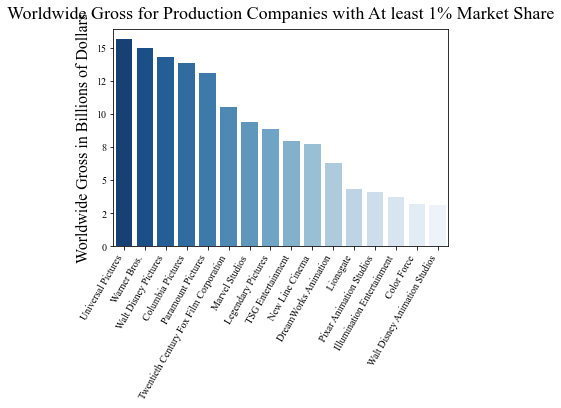

In [73]:
# grab the cumulative gross earned by production companies with at least 1% of the "market share" in film-making worldwide
top_pcs_total_gross = grouped_by_pc.loc[ grouped_by_pc['percentage_of_revenue'] > 0.01, 'worldwide_gross' ].\
                    sort_values(ascending=False)

# get labels
centered_labels = [ word.rjust(max(top_pcs_total_gross.index.map(len))) for word in top_pcs_total_gross.index ]

#plot a bar chart of total gross earned by these "top" production companies
fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(top_pcs_total_gross.index, top_pcs_total_gross, palette='Blues_r')
ax.set_title('Worldwide Gross for Production Companies with At least 1% Market Share', fontname='Times New Roman',\
            fontsize=18, pad=10)
ax.set_ylabel(ylabel='Worldwide Gross in Billions of Dollars', fontsize=16, fontname='Times New Roman')
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000000) for x in current_values])

plt.xticks(rotation=60, ha='right');

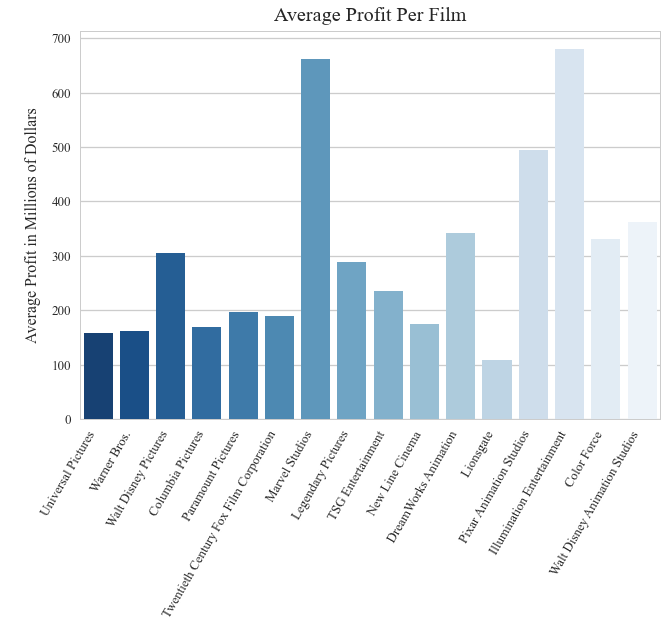

In [74]:
# get average profit per film for top 16 production companies, ordered by total worldwide gross, descending
data2 = movies_by_production_companies.groupby('production_companies').mean().loc[top_pcs_total_gross.index]['profit']

fig, ax = plt.subplots()

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

sns.barplot(data2.index, data2, palette='Blues_r')
ax.set_title('Average Profit Per Film', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel(ylabel='Average Profit in Millions of Dollars', fontsize=16, fontname='Times New Roman',labelpad=10)
ax.set_xlabel(xlabel='', fontsize=16, fontname='Times New Roman')
ax.set_xticklabels(centered_labels, fontname='Times New Roman')

# fix y-ticklabels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x/1000000) for x in current_values], fontname='Times New Roman')

plt.xticks(rotation=60, ha='right');

The top production companies by total gross are NOT the same as the top production companies by average gross. I immediately wonder if some of these production companies are "newer", or have not produced as many films as the others for some reason. Could they have had a streak of beginner's luck that is skewing their average gross metric? Regardless, if this is the case, then they have had some really good luck, because they already have over 1% of the market share in the film industry worldwide.

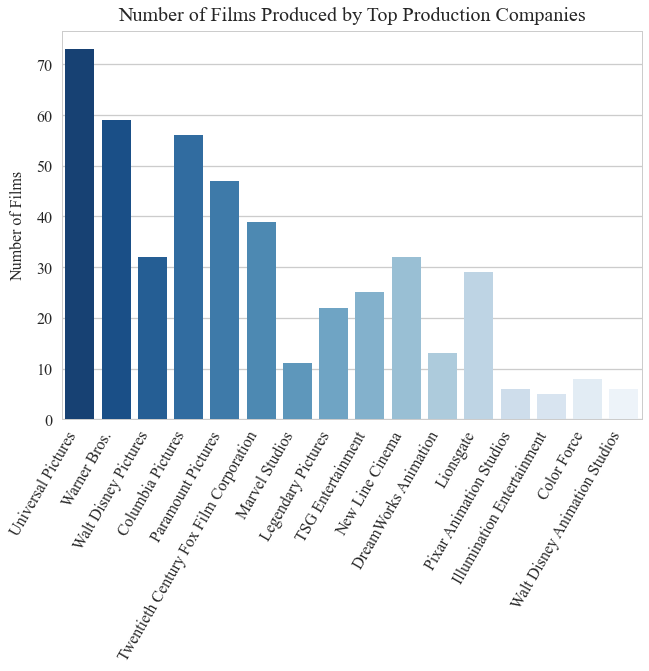

In [75]:
# get number of films produced by top 16 production companies, still ordered by total worldwide gross, descending

heights = [len(movies_by_production_companies.loc[movies_by_production_companies.production_companies==movie])\
 for movie in list(top_pcs_total_gross.index)]

style.use('seaborn-talk')
style.use('seaborn-whitegrid')

fig, ax = plt.subplots()

sns.barplot(top_pcs_total_gross.index, heights, palette='Blues_r')

ax.set_title('Number of Films Produced by Top Production Companies', fontname='Times New Roman', fontsize=20, pad=10)
ax.set_ylabel('Number of Films', fontname='Times New Roman', fontsize=16, labelpad=10)
ax.set_xticklabels(top_pcs_total_gross.index, fontname='Times New Roman', fontsize=16)
ax.set_xlabel('')

plt.xticks(rotation=60, ha='right')
plt.yticks(fontname='Times New Roman', fontsize=16);

Indeed, Marvel Studios and Illumination Entertainment have not made as many films as some of the less successful production companies by average gross. I still think that they are contenders in the space, if only by market share, but it tempers my enthusiasm about their average gross metric. Just for fun, let's try to balance the total gross and average gross metrics; grab any production companies who have made at least 15 films with an average profit of $300 million.

In [76]:
# grab production companies who have made at least 15 films & have an average profit of $300 million
query = ''' SELECT production_companies
            FROM movies_by_production_companies
            GROUP BY production_companies
            HAVING (COUNT() >= 15) AND (AVG(profit) > 300000000)
            '''

psdf(query)

,production_companies
0,Walt Disney Pictures


Wow! It's only Walt Disney. My parameters were sort of arbitrary - why 15 movies? Why \$300 million? But this is still interesting that only this one production companies produced at least 15 films with an average worldwide gross of at least \\$300 million.

Now I am interested in the performance of each of the top production companies over time. Have some production companies been "growing" in terms of cumulative worldwide gross year by year?

In [77]:
# for "top" production companies by market share, get worldwide gross BY YEAR
query = ''' WITH large_production_companies AS (
                                                SELECT production_companies
                                                FROM movies_by_production_companies
                                                GROUP BY production_companies
                                                HAVING SUM(percentage_of_revenue) >= 0.01
                                                )
            SELECT production_companies, start_year, SUM(worldwide_gross) AS gross_per_year
            FROM movies_by_production_companies
            WHERE production_companies IN large_production_companies
            GROUP BY production_companies, start_year
            ;
            '''

pc_over_time = psdf(query)

In [78]:
pc_over_time

,production_companies,start_year,gross_per_year
0,Color Force,2010.0,7.695431e+07
1,Color Force,2011.0,1.328639e+08
2,Color Force,2012.0,6.779234e+08
3,Color Force,2013.0,8.648680e+08
4,Color Force,2014.0,8.243997e+08
...,...,...,...
97,Warner Bros.,2012.0,2.115050e+09
98,Warner Bros.,2013.0,2.653091e+09
99,Warner Bros.,2014.0,2.656922e+09
100,Warner Bros.,2015.0,1.939743e+09


In [79]:
# Create a list of companies in the same order as they are in the production companies column, to iterate over to get a
# cumulative gross column by production company
list_of_companies = [ company for company in pc_over_time.production_companies.values ]

# Get rid of duplicates, but preserve order
cleaned_list_of_companies = []
for company in list_of_companies:
    if company in cleaned_list_of_companies:
        continue
    else:
        cleaned_list_of_companies.append(company)

In [80]:
cleaned_list_of_companies

['Color Force',
 'Columbia Pictures',
 'DreamWorks Animation',
 'Illumination Entertainment',
 'Legendary Pictures',
 'Lionsgate',
 'Marvel Studios',
 'New Line Cinema',
 'Paramount Pictures',
 'Pixar Animation Studios',
 'TSG Entertainment',
 'Twentieth Century Fox Film Corporation',
 'Universal Pictures',
 'Walt Disney Animation Studios',
 'Walt Disney Pictures',
 'Warner Bros.']

In [81]:
# Create a new dataframe with a cumulative gross column by production company

dfs_to_concat = []

for company in cleaned_list_of_companies:
    # Make a copy of slice of records with this production company
    company_records = pc_over_time.loc[pc_over_time.production_companies == company].copy()
    
    # Make a new column with cumulative gross
    company_records['cumulative_gross'] = company_records['gross_per_year'].cumsum()
    
    # Append to "dataframes to concatenate" list
    dfs_to_concat.append(company_records)

# Concatenate all edited production company slices
pc_over_time_w_cumulative_gross = pd.concat(dfs_to_concat).reset_index(drop=True)

In [82]:
pc_over_time_w_cumulative_gross.head()

,production_companies,start_year,gross_per_year,cumulative_gross
0,Color Force,2010.0,76954311.0,7.695431e+07
1,Color Force,2011.0,132863886.0,2.098182e+08
2,Color Force,2012.0,677923379.0,8.877416e+08
3,Color Force,2013.0,864868047.0,1.752610e+09
4,Color Force,2014.0,824399664.0,2.577009e+09


''

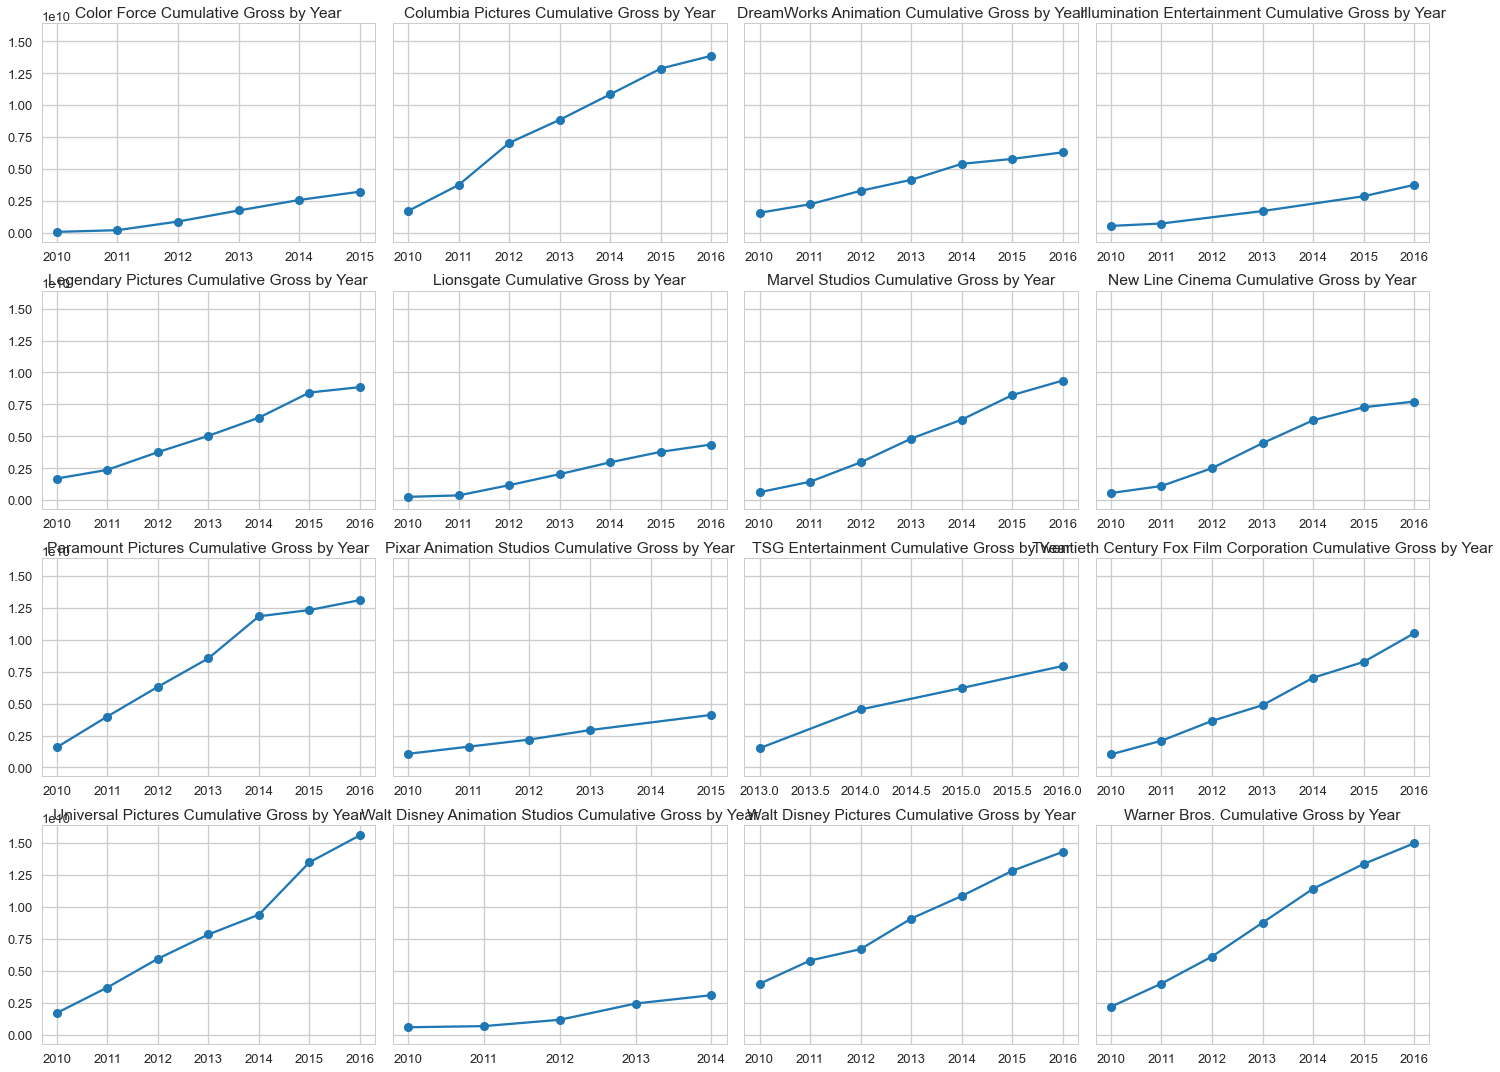

In [83]:
# Plot the cumulative gross of each production company over time in each subplot
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,15), sharey=True)

for n in range(0,16):
    rownum = n // 4 # result of floor division by 4; should cycle 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, etc.
    colnum = n % 4 # remainder of division by 4; should cycle 0, 1, 2, 3, 0, 1, 2, 3, etc.
    data = pc_over_time_w_cumulative_gross.loc[ pc_over_time_w_cumulative_gross['production_companies'] ==\
                                               cleaned_list_of_companies[n] ]
    
    ax[rownum][colnum].plot('start_year', 'cumulative_gross', data=data, marker='o', linestyle='-' )
    ax[rownum][colnum].set_title(cleaned_list_of_companies[n] + ' Cumulative Gross by Year')

plt.tight_layout()
;

These are interesting charts. All are increasing, but at varying rates; and while some are increasing linearly, a lot of them look like they are "leveling off" around 2016. I am not going to include production company related recommendations in my presentation, so I am abandoning my analysis here.

### Playing with Barplot Styling
I am keeping the plot below in my appendix because I did a lot of work customizing the plot, and I want to be able to reference back to what I did. But the actual contents of the bar chart (top 10 genres by total worldwide gross) is irrelevant to my analysis at this point.

A note on the color choices in the plot: this bar chart was going to be displayed on a dark background, so the tick labels, axis labels, etc. are in white. They don't show up on the chart below, but they would be visible on a dark background in a powerpoint (if I am understanding how this works correctly.)

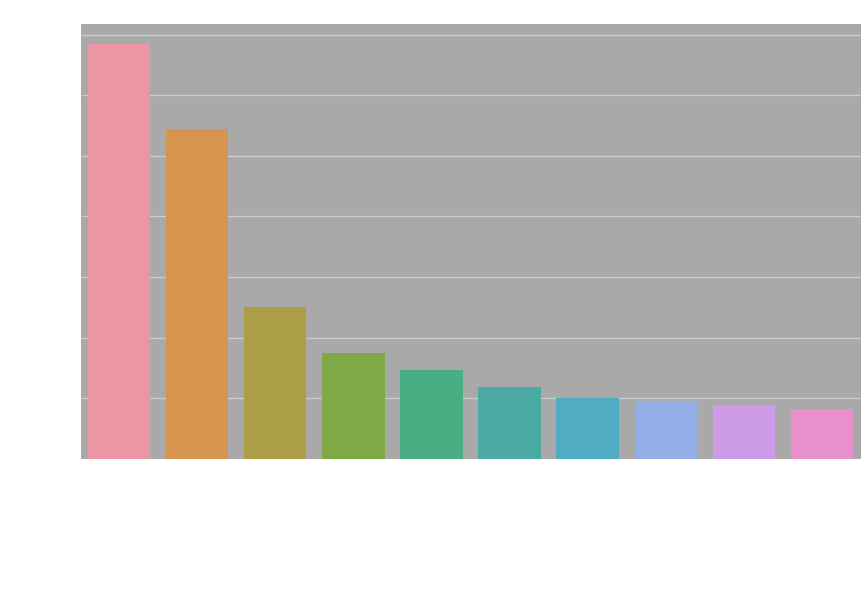

In [84]:
with plt.style.context('seaborn-pastel'):
    data = movies_w_genres.groupby('genres').sum()['worldwide_gross'].sort_values(ascending=False)[:10]

    centered_labels = [ word.center(26) for word in data.index ]

    centered_labels[9] = 'Comedy '

    fig, ax = plt.subplots(figsize=(14,8))

    bars = sns.barplot(centered_labels, data/1000000000)

    ax.set(title='Total Worldwide Gross by Genre', ylabel='Total Worldwide Gross in Billions ($)')

    ax.set_xticks(range(len(data)))
    
    plt.xticks(rotation=45, ha='right')
    
    # color plot background light grey
    ax.set_facecolor('#a9a9a9')
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # color remaining spines
    ax.spines['left'].set_color('#fff')
    ax.spines['bottom'].set_color('#fff')
    
    # Make label colors for bars match bar colors
    list_of_colors = [patch.get_facecolor() for patch in bars.patches]
    n=0
    for t in ax.xaxis.get_ticklabels():
        t.set_color(list_of_colors[n])
        n+=1
    
    # Make color of tick lines match visible spines
    ax.tick_params(colors='#fff')
    
    # Make color of y-axis tick labels match visible spines
    [t.set_color('#fff') for t in ax.yaxis.get_ticklabels()]
    
    # Make color of y-axis label match visible spines
    ax.yaxis.label.set_color('#fff')
    
    # Make color of title match visible spines
    ax.title.set_color('#fff');

    # bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # width, height = bbox.width*fig.dpi, bbox.height*fig.dpi
    # height is 2/3 of width;

### Play around with making word clouds with keywords from films in the various quartile bands of the top genre

The word clouds below didn't render any significant findings about the difference between a low-performing action/adventure/science-fiction film and a high-performing one. However, I am leaving them in the appendix as a reference for myself the next time I make a word cloud.

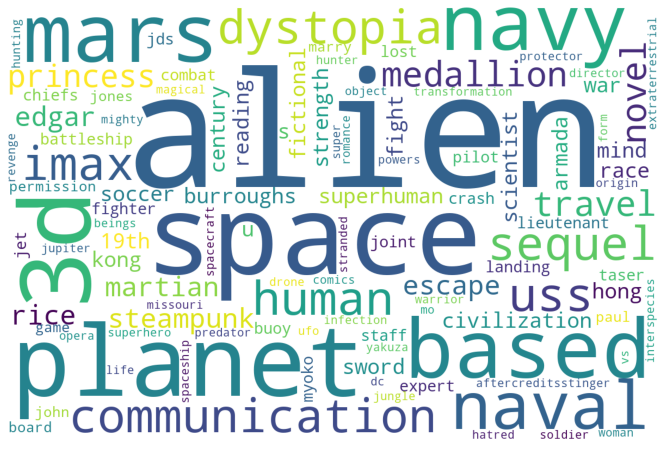

In [87]:
# Get keywords field in a usable format (string-ified json to list)

def to_list(value):
    if value == '[]':
        return None
    elif value is None:
        return None
    else:
        return [ pc_dict['name'] for pc_dict in json.loads(value) ]
    
movies_w_genres['keywords'] = movies_w_genres['keywords'].map(to_list)

# Make word cloud for bottom 25% of films in top genre

# Find index for each film in bottom 25% of worldwide gross

bottom_quarter_films = ww_gross_top_genre.loc[ ww_gross_top_genre < ww_gross_top_genre.describe()['25%'] ].index

# Loop through key words, and append each word to one long string

text_for_cloud = ''
for list_of_words in movies_w_genres.loc[bottom_quarter_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud = text_for_cloud + ' "' + word + '"'
            
# Generate word cloud with one long string

from wordcloud import WordCloud

cloud = WordCloud(width=1200, height=800, background_color='white').generate(text_for_cloud)

plt.figure(figsize=(12, 8)) # adjust figsize so that wordcloud can expand to given width & height

plt.imshow(cloud) # show the plot!

plt.axis('off') # don't show axis spines

plt.tick_params(length=0) # don't show tickmarks

# don't show tick labels
plt.xticks([])
plt.yticks([]);

# Repeat for each category (middle 50% of worldwide gross, and top 25% of worldwide gross)


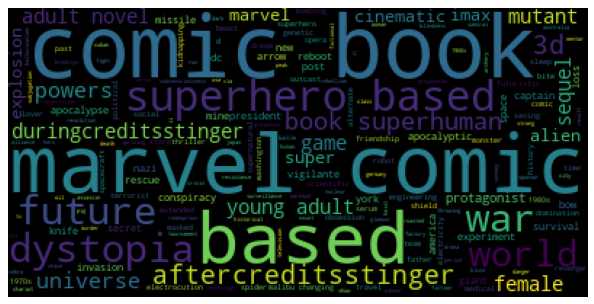

In [88]:
# Middle 50%

middle_half_films = ww_gross_top_genre.loc[ (ww_gross_top_genre > ww_gross_top_genre.describe()['25%'])\
                                          & (ww_gross_top_genre < ww_gross_top_genre.describe()['75%'])].index

text_for_cloud2 = ''
for list_of_words in movies_w_genres.loc[middle_half_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud2 = text_for_cloud2 + ' "' + word + '"'

cloud = WordCloud().generate(text_for_cloud2)
plt.imshow(cloud)
plt.tick_params(length=0)
plt.xticks([])
plt.yticks([]);

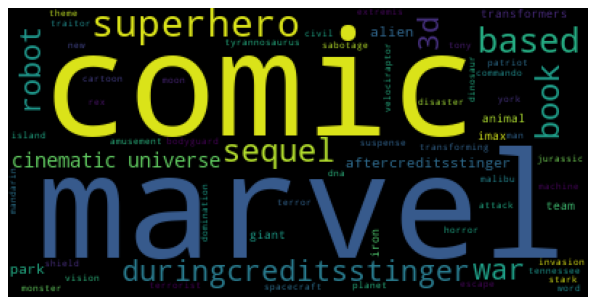

In [90]:
# Top 25%

top_quarter_films = ww_gross_top_genre.loc[ ww_gross_top_genre > ww_gross_top_genre.describe()['75%'] ].index

text_for_cloud3 = ''
for list_of_words in movies_w_genres.loc[top_quarter_films, 'keywords']:
    if list_of_words is None:
        continue
    else:
        for word in list_of_words:
            text_for_cloud3 = text_for_cloud3 + ' "' + word + '"'

cloud = WordCloud().generate(text_for_cloud3)
plt.imshow(cloud)
plt.tick_params(length=0)
plt.xticks([])
plt.yticks([]);